Heart Disease in Cleveland
=====
**An analysis by Group 20 DSCI 100 007**

Phoebe McNair-Luxon, Alexandre Beauchemin, Kumaravendhan Ravichandran, Evi Dorsch

Data set source: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [2]:
library(tidyverse)
library(tidymodels)
library(repr)
library(gridExtra)
library(readxl)
set.seed(4200)
install.packages("themis")
library(themis)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Part 1: Data Cleaning and Preliminary  Analysis
=====
Cell 1: Summary of the data set

Cell 2: Visuization of the data set

In [3]:
# read in data 
Cl_heart_data <- read.table("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", sep = ",",
                 col.names = c("age", "sex", "cp", "trestbps", "chol", "fbs",  "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))
#convert from a dataframe to a tibble
Cl_heart_data <- as_tibble(Cl_heart_data)

# convert num from from dbl to factor
Cl_heart_data_2 <- Cl_heart_data |> 
    mutate(num=as_factor(num))

# collapse factor levels returning positive disease diagnosis
Cl_heart_data_2 <-  fct_collapse(Cl_heart_data_2$num,
    "No disease" = "0",
    "Disease" = c("1", "2", "3", "4")) |>
    bind_cols(Cl_heart_data_2)

# rename column
colnames(Cl_heart_data_2) <- c("disease_status", "age", "sex", "cp", "trestbps", "chol", "fbs",  "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

# select for columns 
clean_heart_data <- Cl_heart_data_2 |>
    select("age", "sex", "trestbps", "chol", "fbs", "oldpeak", "disease_status")

# rename column
colnames(clean_heart_data) <- c("age", "sex", "trestbps", "chol", "fbs", "oldpeak", "num")

# count number of observations for disease and no disease for use in next cell
count_before_balancing <- count(clean_heart_data, num)

# balance data
ups_recipe <- recipe(num ~ ., data = clean_heart_data) |>
  step_upsample(num, over_ratio = 1, skip = FALSE) |>
  prep()

clean_heart_data <- bake(ups_recipe, clean_heart_data)

# count number of observations for disease and no disease for use in next cell
count_after_balancing <- count(clean_heart_data, num)

#splitting data into training and testing sets
heart_data_split <-  initial_split(clean_heart_data, prop = 0.75, strata = num)
heart_train <- training(heart_data_split)
heart_test <- testing(heart_data_split)
# head(heart_train)
# head(heart_test)

#create new data frame without num for calculating stats
heart_train_1 <- heart_train |>
    select(-num)

# visualizing the data (only training data)
names <- c("Mean", "Median")
mean_1 <- heart_train_1 |>
    map_df(mean, na.rm = TRUE)
median_1 <- heart_train_1 |>
    map_df(median, na.rm = TRUE)
tbl1 <- bind_rows(mean_1, median_1)
exploratory_analysis <- bind_cols(names, tbl1)

#calcualte number of rows in training dataset
number_of_rows <- heart_train |>  
    nrow()

New names:
• `` -> `...1`
New names:
• `` -> `...1`


In [4]:
#bind the two counts and label data with human readable names
count_data <- bind_cols(count_before_balancing, count_after_balancing) |>
    select(-num...3)
titles<- c("Disease Status", "Before Balancing", "After Balancing")
colnames(count_data) <- titles
count_data

New names:
• `num` -> `num...1`
• `n` -> `n...2`
• `num` -> `num...3`
• `n` -> `n...4`


Disease Status,Before Balancing,After Balancing
<fct>,<int>,<int>
No disease,164,164
Disease,139,164


**Table 1: Distribution of observations in entire data set before and after balancing.** Data set was 46% healthy patients and 54% patients with heart disease. This is not heavily skewed, however to ensure the best accuracy balancing was employed, after which the distribution was 50% healthy and 50% with heart disease. 

In [5]:
#print counts 
print("Number of Rows for all variables in training data set: (no NA values)")
number_of_rows

#print means and medians 
exploratory_analysis

[1] "Number of Rows for all variables in training data set: (no NA values)"


[1] 246

...1,age,sex,trestbps,chol,fbs,oldpeak
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mean,54.87805,0.6707317,133.2886,249.8333,0.1585366,1.054472
Median,55.50000,1.0000000,130.0000,245.0000,0.0000000,0.800000


**Table 2: Summary statistics**: Mean and Median of all variables used in predictions of heart disease from the 246 total observations. By visual inspection, no NA values were found in any of the parameters used. 

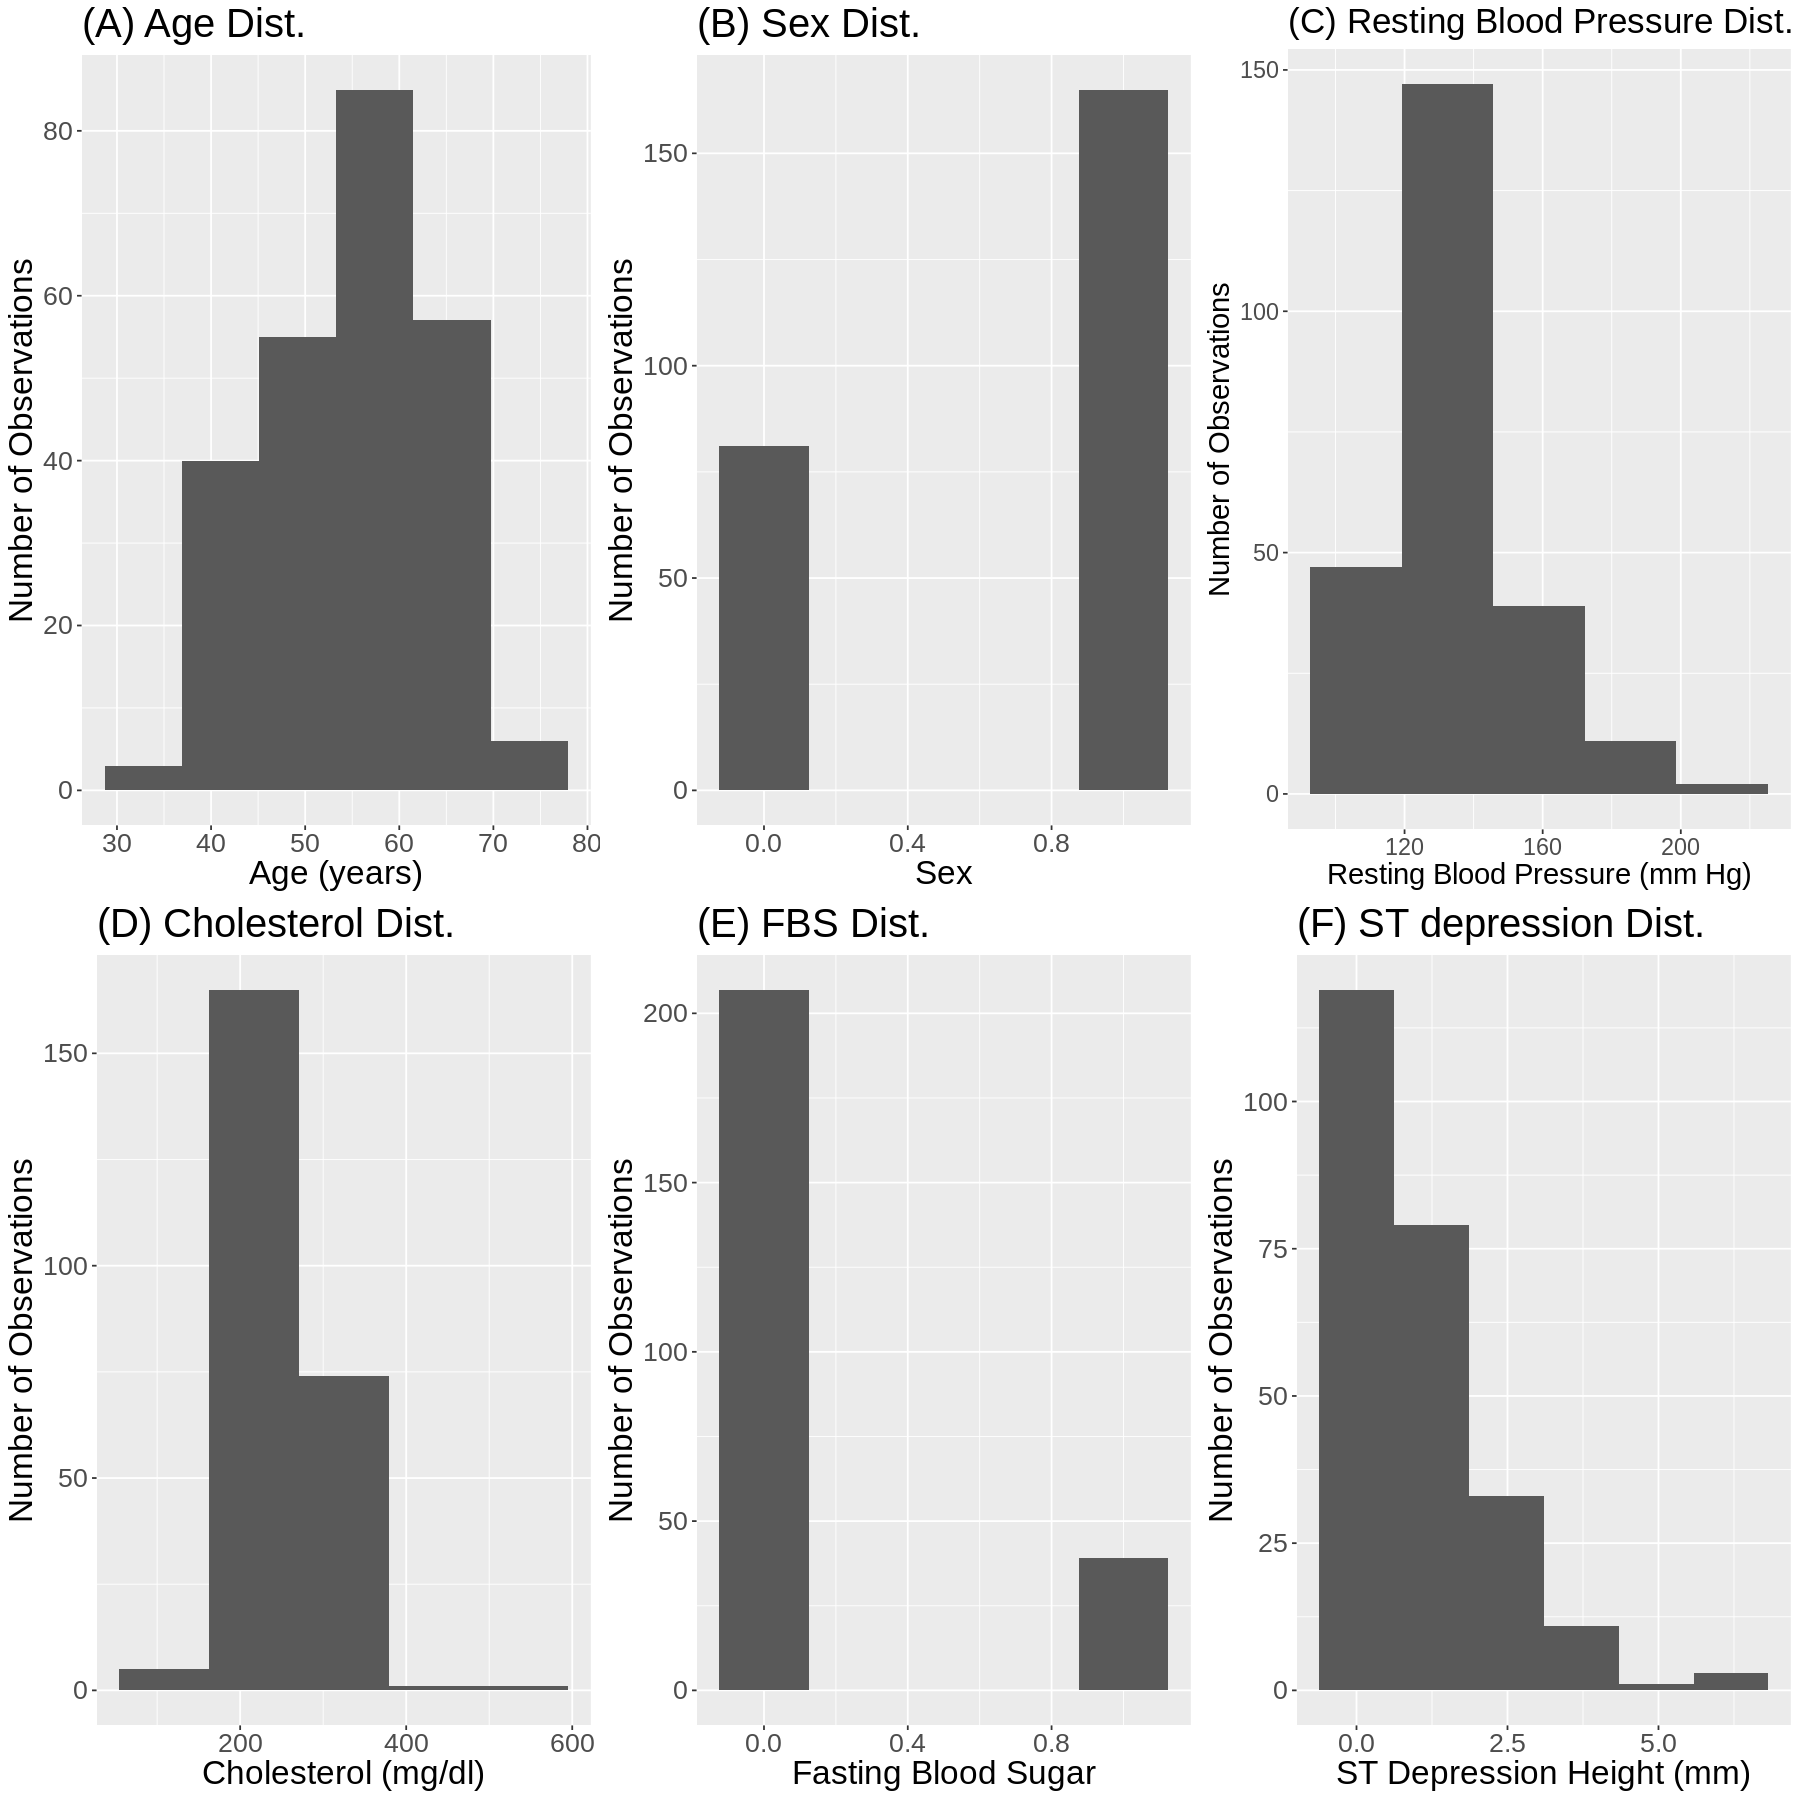

In [6]:
options(repr.plot.height = 15, repr.plot.width = 15)

# Visulize data distribution in a graph
age_distribution <- heart_train |>
    ggplot() +
    geom_histogram(bins = 6, aes(x=age)) +
    labs(x="Age (years)",y = "Number of Observations") +
    ggtitle("(A) Age Dist.") +
    theme(text=element_text(size=20))

sex_distribution <- heart_train |>
    ggplot() +
    geom_histogram(bins = 5, aes(x=sex)) +
    labs(x="Sex",y = "Number of Observations") +
    ggtitle("(B) Sex Dist.") +
    theme(text=element_text(size=20))

trestbps_distribution <- heart_train |>
    ggplot() +
    geom_histogram(bins = 5,aes(x=trestbps)) +
    labs(x="Resting Blood Pressure (mm Hg)",y = "Number of Observations") + 
    ggtitle("(C) Resting Blood Pressure Dist.") +
    theme(text=element_text(size=17.5))

chol_distribution <- heart_train |>
    ggplot() +
    geom_histogram(bins = 5,aes(x=chol)) +
    labs(x="Cholesterol (mg/dl)",y = "Number of Observations") +
    ggtitle("(D) Cholesterol Dist.")+
    theme(text=element_text(size=20))

fbs_distribution <- heart_train |>
    ggplot() +
    geom_histogram(bins = 5 ,aes(x=fbs)) +
    labs(x="Fasting Blood Sugar",y = "Number of Observations") +
    ggtitle("(E) FBS Dist.") +
    theme(text=element_text(size=20))

oldpeak_distribution <- heart_train |>
    ggplot() +
    geom_histogram(bins = 6,aes(x=oldpeak)) +
    labs(x="ST Depression Height (mm)",y = "Number of Observations") +
    ggtitle("(F) ST depression Dist.") +
    theme(text=element_text(size=20))

#arrange all graphs to print together
grid.arrange(age_distribution,sex_distribution,trestbps_distribution, chol_distribution,
             fbs_distribution, oldpeak_distribution, ncol =3)


**Figure 1: Distribution of data within each variable.** Each individual graph shows the distribution of data within the variable, with a number of observations on the y-axis. Each variable has 303 observations (n=303). Bin size is dependent on variables as all data is non-scaled at this point. Note: Dist. means Distribution. **(A)** Age Distribution. Age is distributed normally with the most patients being between 50 and 60, and few patients under 30 or over 70. The mean age of this population is 55 and the median 56, supporting a normal distribution. **(B)** Sex Distribution. If the patient’s sex is female they are assigned a value of 0, if their sex is male they are assigned a value of 1. About ⅔ of the patient’s have a sex of male. **(C)** Rest Blood Pressure: Blood pressure has a slightly positively skewed distribution. The mean of the systolic blood pressure was 132.38mmHg, the median is 130mmHg. **(D)** Cholesterol Distribution: Cholesterol is slightly positively skewed. The mean is 247.65mg/dl, the median is 244mg/dl.  **(E)** FBS Distribution. If the patient has a FBS greater than 120 mg/dl they are assigned a variable of 1, if the FBS is less than this they are assigned 0.  About 90% of the patients have FBS under 120 mg/dl. **(F)**  ST Depression Distribution: The ST depression is positively skewed. The mean is 1.08mm, the median 0.80mm.

Part 2: Running the Analysis
=====
Analysis with just Census Data
----

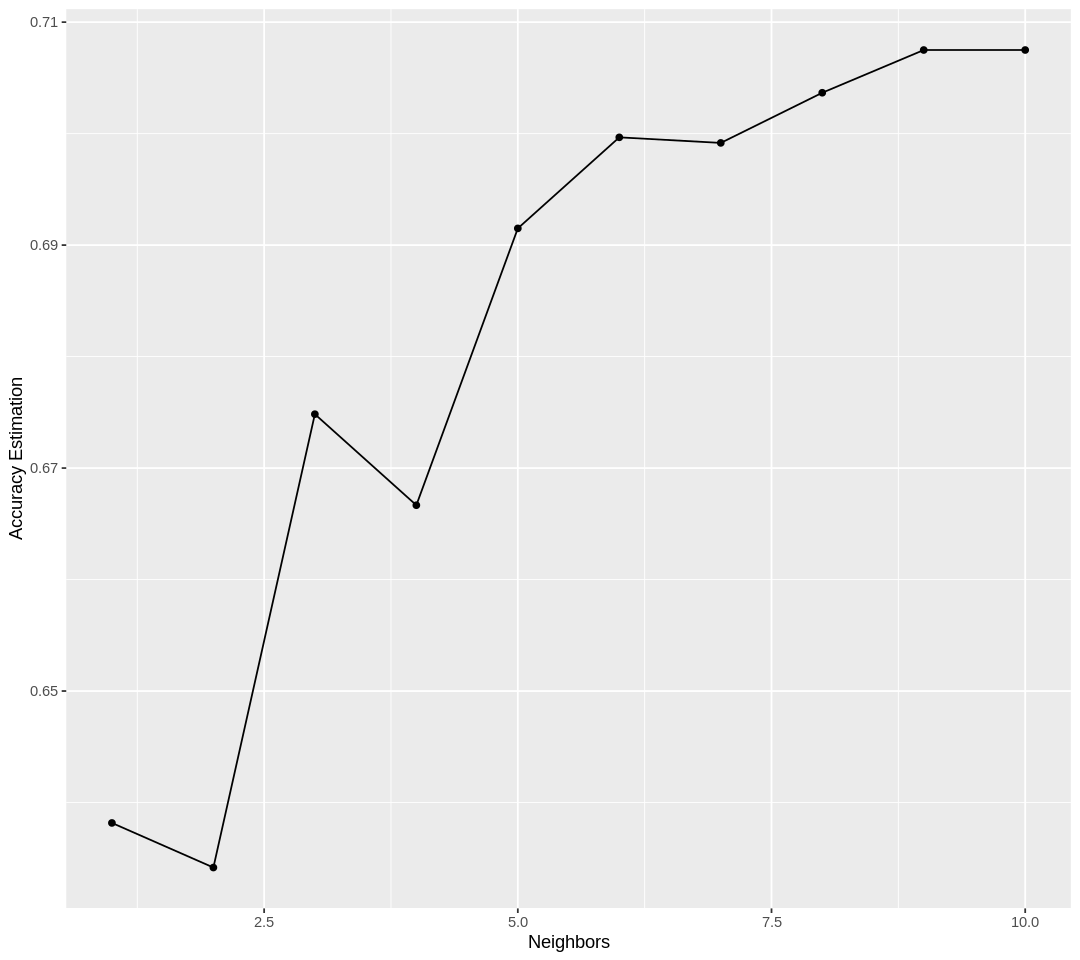

In [7]:
#Analysis with just Census Data
#Analysis with all Paremeters
set.seed(4200)
options(repr.plot.height = 8, repr.plot.width = 9)
#select relevant parameters
heart_train_census <- heart_train |>
    select("age", "sex", "num")
heart_test_census <- heart_test |>
    select("age", "sex", "num")

#make recipe with tune() function
heart_recipe_census <- recipe(num ~ ., data = heart_train_census) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#make a vfold
heart_vfold_census <- vfold_cv(heart_train_census, v =5, strata = num)

#make a tuning spec 
heart_spec_tune_census <- nearest_neighbor(weight_func = "rectangular", 
                                   neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# make tibble of K values to try 
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

#collect metrics 
heart_workflow_census <- workflow() |>
       add_recipe(heart_recipe_census) |>
       add_model(heart_spec_tune_census)|>
       tune_grid(resamples = heart_vfold_census, grid = k_vals) 

accuracies_census <- heart_workflow_census |>
       collect_metrics() |> #sum of the SD and the mean 
       filter(.metric == "accuracy")

#plot the accuracies
accuracy_vs_k_census <- ggplot(accuracies_census, aes(x = neighbors, y= mean)) +
       geom_point() +
       geom_line() +
      labs(x= "Neighbors", y = "Accuracy Estimation")
accuracy_vs_k_census

#at this point we evaluate the accuracy of the model below to choose the best K

In [8]:
#We now create a model using the best K chosen from above
set.seed(4200)
#make a new spec 
heart_spec_census <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

#make a new workflow (retrain mdoel) 
heart_fit_census <- workflow() |>
    add_recipe(heart_recipe_census) |>
    add_model(heart_spec_census) |>
    fit(data = heart_train_census)

#predict the accuracy of prediction while only using medical predictors
heart_predicted_census <- predict(heart_fit_census, heart_test_census) |>
    bind_cols(heart_test_census)

#produce the accuracy of prediction while only using census predictors
acc_census <- heart_predicted_census |>
    metrics(truth = num, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()
tibble(acc_census)

#create a confusion matrix with Truth and Prediction values of diagnosis
confusion_census <- heart_predicted_census|>
             conf_mat(truth = num, estimate = .pred_class)
confusion_census

#Calculate the percentage wrong predictions that are false positive
false_positive_census <- 18/82

#Calculate the percentage wrong predictions that are false negative
false_negative_census <- 7/82

#Produce a tibble with false_positive and false_negative values
tibble(false_positive_census, false_negative_census)

acc_census
<dbl>
0.695122


            Truth
Prediction   No disease Disease
  No disease         23       7
  Disease            18      34

false_positive_census,false_negative_census
<dbl>,<dbl>
0.2195122,0.08536585


Analysis with just Medical Data
-----

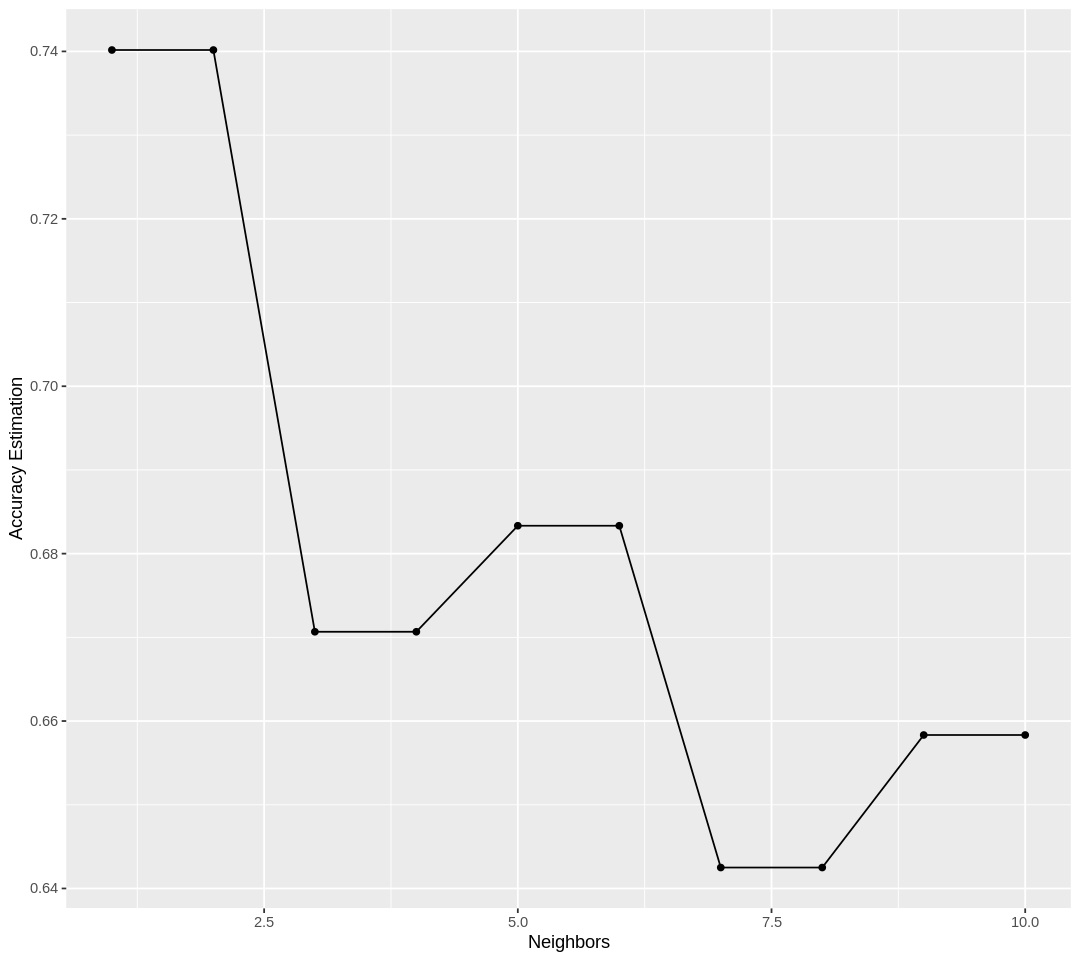

In [9]:
#Analysis with just Medical Data
#Analysis with all Paremeters
set.seed(4200)
options(repr.plot.height = 8, repr.plot.width = 9)
#select relevant parameters
heart_train_med <- heart_train |>
    select("trestbps", "chol", "fbs", "oldpeak", "num")
heart_test_med <- heart_test |>
    select("trestbps", "chol", "fbs", "oldpeak", "num")

#make recipe with tune() function
heart_recipe_med <- recipe(num ~ ., data = heart_train_med) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#make a vfold
heart_vfold_med <- vfold_cv(heart_train_med, v =5, strata = num)

#make a tuning spec 
heart_spec_tune_med <- nearest_neighbor(weight_func = "rectangular", 
                                   neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# make tibble of K values to try 
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

#collect metrics 
heart_workflow_med <- workflow() |>
       add_recipe(heart_recipe_med) |>
       add_model(heart_spec_tune_med)|>
       tune_grid(resamples = heart_vfold_med, grid = k_vals) 

accuracies_med <- heart_workflow_med |>
       collect_metrics() |> #sum of the SD and the mean 
       filter(.metric == "accuracy")

#plot the accuracies
accuracy_vs_k_med <- ggplot(accuracies_med, aes(x = neighbors, y= mean)) +
       geom_point() +
       geom_line() +
      labs(x= "Neighbors", y = "Accuracy Estimation")
accuracy_vs_k_med

#at this point we evaluate the accuracy of the model below to choose the best K

In [10]:
#We now create a model using the best K chosen from above
set.seed(4200)
#make a new spec 
heart_spec_med <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

#make a new workflow (retrain mdoel) 
heart_fit_med <- workflow() |>
    add_recipe(heart_recipe_med) |>
    add_model(heart_spec_med) |>
    fit(data = heart_train_med)

#predict the accuracy of prediction while only using medical predictors
heart_predicted_med <- predict(heart_fit_med, heart_test_med) |>
    bind_cols(heart_test_med)

#create a confusion matrix with Truth and Prediction values of diagnosis
confusion_med <- heart_predicted_med|>
             conf_mat(truth = num, estimate = .pred_class)
confusion_med

#produce the accuracy of prediction while only using medical predictors
acc_med <- heart_predicted_med |>
    metrics(truth = num, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()
acc_med

#Calculate the percentage wrong predictions that are false positive
false_positive_med <- 13/82

#Calculate the percentage wrong predictions that are false negative
false_negative_med <- 9/82

#Produce a tibble with false_positive and false_negative values
tibble(false_positive_med, false_negative_med)

            Truth
Prediction   No disease Disease
  No disease         28       9
  Disease            13      32

[1] 0.7317073

false_positive_med,false_negative_med
<dbl>,<dbl>
0.1585366,0.1097561


Analysis with All Parameters
----

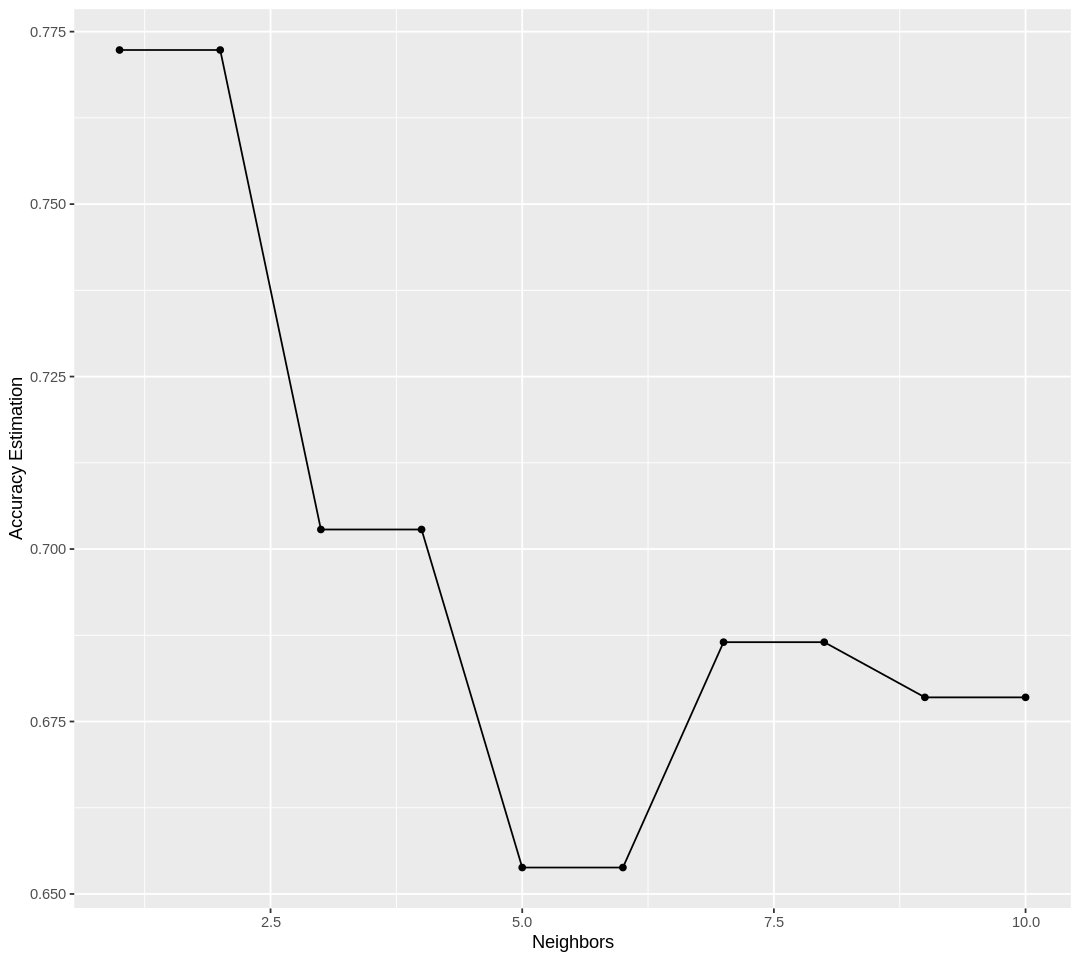

In [11]:
#Analysis with all Paremeters
set.seed(4200)
options(repr.plot.height = 8, repr.plot.width = 9)

#select relevant parameters
heart_train_all <- heart_train |>
    select("age", "sex", "trestbps", "chol", "fbs", "oldpeak", "num")
heart_test_all <- heart_test |>
    select("age", "sex", "trestbps", "chol", "fbs", "oldpeak", "num")

#make recipe with tune() function
heart_recipe_all <- recipe(num ~ ., data = heart_train_all) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#make a vfold
heart_vfold_all <- vfold_cv(heart_train_all, v =5, strata = num)

#make a tuning spec 
heart_spec_tune_all <- nearest_neighbor(weight_func = "rectangular", 
                                   neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# make tibble of K values to try 
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

#collect metrics 
heart_workflow_all <- workflow() |>
       add_recipe(heart_recipe_all) |>
       add_model(heart_spec_tune_all)|>
       tune_grid(resamples = heart_vfold_all, grid = k_vals) 

accuracies_all <- heart_workflow_all |>
       collect_metrics() |> #sum of the SD and the mean 
       filter(.metric == "accuracy")

#plot the accuracies
accuracy_vs_k_all <- ggplot(accuracies_all, aes(x = neighbors, y= mean)) +
       geom_point() +
       geom_line() +
      labs(x= "Neighbors", y = "Accuracy Estimation")
accuracy_vs_k_all

#at this point we evaluate the accuracy of the model below to choose the best K

In [12]:
#We now create a model using the best K chosen from above
set.seed(4200)
#make a new spec 
heart_spec_all <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

#make a new workflow (retrain mdoel) 
heart_fit_all <- workflow() |>
    add_recipe(heart_recipe_all) |>
    add_model(heart_spec_all) |>
    fit(data = heart_train_all)

# predict the accuracy of prediction while only using medical predictors
heart_predicted_all <- predict(heart_fit_all, heart_test_all) |>
    bind_cols(heart_test_all)

# produce the accuracy of prediction while only using medical predictors
acc_all <- heart_predicted_all |>
    metrics(truth = num, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()
acc_all

#create a confusion matrix with Truth and Prediction values of diagnosis
confusion_all <- heart_predicted_all|>
             conf_mat(truth = num, estimate = .pred_class)
confusion_all

#Calculate the percentage wrong predictions that are false positive
false_positive_all <- 13/82

#Calculate the percentage wrong predictions that are false negative
false_negative_all <- 6/82

#Produce a tibble with false_positive and false_negative values
tibble(false_positive_all, false_negative_all)

            Truth
Prediction   No disease Disease
  No disease         28       6
  Disease            13      35

false_positive_all,false_negative_all
<dbl>,<dbl>
0.1585366,0.07317073


Visualizing the Models
---
Step 1: Combine all of the accuracy data into one dataframe

Step 2: Plot the accuracies of the different models as bar graphs

In [13]:
#bind all of the accuracies together 
accuracy_data <- bind_cols(acc_census,acc_med, acc_all) 
names <- c("Census_Accuracy","Medical_Accuracy", "All_Accuracy")
colnames(accuracy_data) <- names

#tidy the accuracy data (make in tidy format) 
tidy_accuracy_data <- pivot_longer(accuracy_data, 
            cols = Census_Accuracy:All_Accuracy, 
            names_to = "data_set", 
            values_to = "accuracy")
tidy_accuracy_data                     

New names:
• `` -> `...1`
• `` -> `...2`
• `` -> `...3`


data_set,accuracy
<chr>,<dbl>
Census_Accuracy,0.6951220
Medical_Accuracy,0.7317073
All_Accuracy,0.7682927


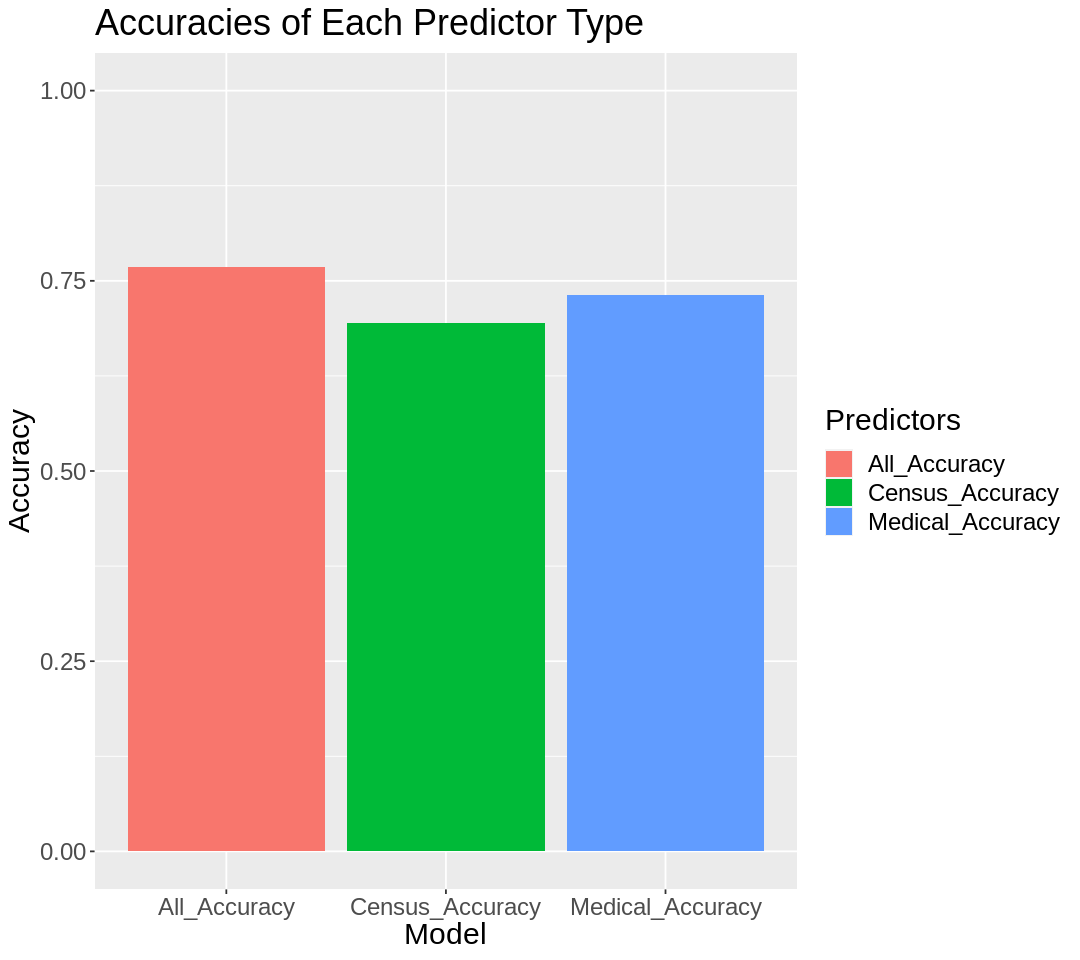

In [14]:
#plot the accuracies as a bar graph
Accuracy_plot <- tidy_accuracy_data |>
    ggplot(aes(x = data_set, y=accuracy, fill = data_set)) +
    geom_bar(stat = "identity") +
    labs(x= "Model", y="Accuracy", fill = "Predictors") +
    ylim(0:1) +
    ggtitle("Accuracies of Each Predictor Type") +
    theme(text=element_text(size=18))
Accuracy_plot

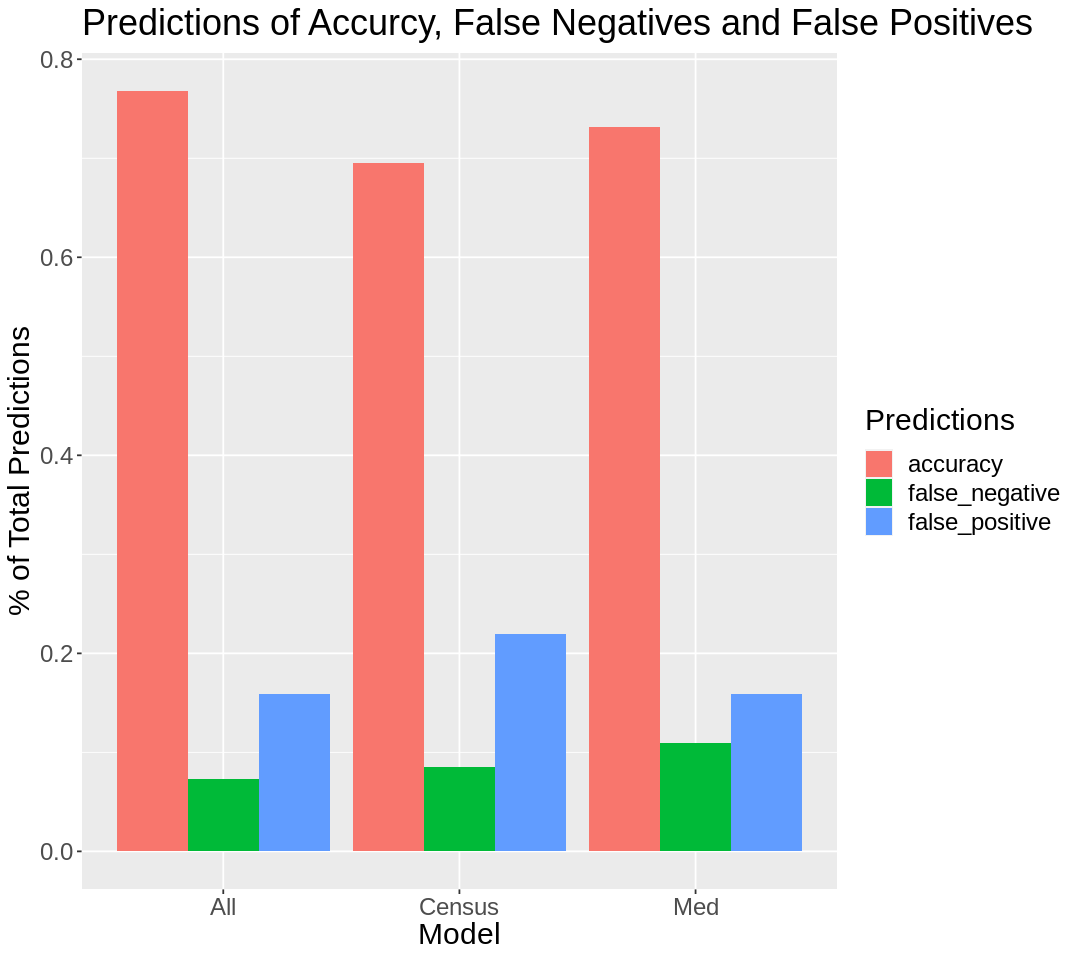

In [15]:
#Create a data frame with accuraxy, false_positive and false_negative values for each type of predictors
error_df <- data.frame(
  model = c("All", "Census", "Med"),
  accuracy = c(acc_all,acc_census, acc_med),
  false_positive = c(false_positive_all, false_positive_census, false_positive_med),
  false_negative = c(false_negative_all, false_negative_census, false_negative_med))

#Modify the data frame to use it to plot bar graph
error_long <- tidyr::gather(error_df, key = "metric", value = "value", -model)

# Create the grouped bar chart
ggplot(error_long, aes(x = model, y = value, fill = metric)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "Model", y = "% of Total Predictions", fill = "Predictions")+
  ggtitle("Predictions of Accurcy, False Negatives and False Positives") +
theme(text=element_text(size=18))